In [85]:

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import pandas as pd

from scipy.special import logsumexp
from scipy.special import softmax
from scipy.stats import invwishart
from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


import random

In [86]:
import numpy as np

In [87]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Import Dataset

In [88]:
dirpath = "./../../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

# 2 Un-Collapsed Gibbs

1) Initialize $\mathbf{z}, \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi}$
2) For $t=0,...,T$
$$\begin{align}
    \text{Sample } \boldsymbol{\pi}^{(t)} &\sim p(\boldsymbol{pi} | \mathbf{z}^{(t-1)}) = \mathrm{Dirichlet}(\boldsymbol{\alpha}_N^{(t-1)}),\\
    &\boldsymbol{\alpha}_N^{(t-1)} = \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k^{(t-1)} = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample } \boldsymbol{\Sigma}^{(t)}, &\boldsymbol{\mu}^{(t)} \sim p(\boldsymbol{\Sigma},\boldsymbol{\mu}|\mathbf{z}^{(t-1)}, \mathbf{X})\\
     &= \prod_k^K \mathrm{NIW}(\mu,\Sigma | \mathbf{m}_N, \kappa_N, \nu_N, \mathbf{S}_N) =  \prod_k^K \mathrm{N}(\mu|\mathbf{m}_N, \frac{1}{\kappa_N}\Sigma) \times \mathrm{IW}(\Sigma | \mathbf{S}_N, \nu_N),\\
        &\qquad\qquad \mathbf{m}_{N_k} = \frac{\kappa_{0_k}m_{0_k} + N_k\bar{\mathbf{x}}_k}{\kappa_{0_k} + N_k}\\
        &\qquad\qquad \kappa_{N_k} = \kappa_{0} + N_k\\
        &\qquad\qquad \nu_{N_k} = \nu_{0} + N_k\\
        &\qquad\qquad \mathbf{S}_{N_k} = \mathbf{S}_{0_k} + \mathbf{S}_{\bar{\mathbf{x}}_k} + \frac{\kappa_{0_k}N_k}{\kappa_{0_k} + N_k}(\bar{\mathbf{x}}_k - m_{0_k})(\bar{\mathbf{x}}_k - m_{0_k})^T\\\\

    \text{Sample } \mathbf{z}^{(t)} \sim &P(\mathbf{z}|\mathbf{X},\boldsymbol{\pi}^{(t)}, \boldsymbol{\theta}^{(t)})\\

        \text{For } i &\in {1,..,N}\\
            &\text{Sample } z_i^{(t)} \sim \text{Categorical}(p_1^{(i)},...,p_K^{(i)}) \quad \text{where,}\\
                &\qquad p_k^{(i)} \propto \pi_k^{(t)} \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_k^{(t)},\boldsymbol{\Sigma}_k^{(t)})\\\\
\end{align}$$

In [89]:
def gaussian_likelihood(X, μ, Σ, π):
    N,D = X.shape
    K = π.shape[0]
    
    logp = np.zeros((N,K))

    for k in range(K):
        logp[:,k] = np.log(π[k]) + multivariate_normal.logpdf(X, mean=μ[k],cov=Σ[k])

    log_norm = logsumexp(logp,axis=1,keepdims=True)

    p = np.exp(logp - log_norm)

    loglik = np.sum(log_norm)/N

    return p,loglik

In [90]:
def sampleZs(p):
    ''' 
        Samples cluster assignments z for n datapoints 

        @param (p) : softmax categorical probabilities over clusters (N, K)
    '''

    # Inverse sample from categorical distribution
    cdf = np.cumsum(p, axis=1) # compute CDF for each row (each categorical distribution)
    u   = rng.random(size=(p.shape[0], 1))
    return (cdf > u).argmax(axis=1)  # return first index where cdf is greater than random u

In [91]:
def sample_π(zs, α_0, K):
    ''' 
        Samples mixing weights from Dirichlet distribution parameterized by pseudocounts of components
        
        @param (zs)  : cluster assignments (n)
        @param (α_0) : Dirichlet prior list (K)
        @param (K)   : the number of components
    '''

    z_counts = np.bincount(zs.astype(np.int64), minlength=K)
    return rng.dirichlet(α_0 + z_counts)

In [92]:
def sample_NIW(X,zs,μ_0,S_0,k_0,ν_0,K):
    N,D = X.shape

    zs_hot = np.eye(K)[zs.astype(int)]
    counts = np.bincount(zs.astype(int), minlength=K)[:, None] # component cardinality 
    nonzero = counts.ravel() > 0 
    x_bar = np.zeros((K, D))
    np.divide(zs_hot.T @ X, counts, out=x_bar, where=nonzero[:, None])

    Σs = np.zeros((K,D,D))
    μs = np.zeros((K,D))

    for k in range(K):
        indices = (zs == k)
        n_k = np.sum(indices)
        k_n = k_0 + n_k

        X_k = X[indices]
        S = (X_k - x_bar[k]).T @ (X_k - x_bar[k])
        diff = (x_bar[k] - μ_0).reshape(-1,1)
        S_n = S_0 + S + ((k_0 * n_k)/(k_n)) * (diff @ diff.T)
        Σs[k] = invwishart.rvs(df=ν_0 + n_k, scale=S_n)


        μ_n = (k_0 * μ_0 + n_k * x_bar[k])/k_n
        μs[k] = np.random.multivariate_normal(mean=μ_n, cov=Σs[k]/k_n)
        
    return Σs,μs

In [93]:
def gibbs(X, num_iter, num_burn, K, rng=np.random.default_rng(random_seed), eps=1e-20) :
    N,D = X.shape

    πs = []
    zs = []
    Σs = []
    μs = []

    # Intialize
    α_0 = np.full(K, 1 / K)  # Dirichlet
    k_0 = 0.01         # Prior confidence in μ_0
    μ_0 = np.zeros((D))  # Prior mean vector 
    ν_0 = D + 1        # DOF for inverse wishart
    S_0 = np.eye(D) * 1e-3# prior scatter matrix

    π = rng.dirichlet(α_0)
    z = np.random.randint(0,K,size=N)
    Σ,μ = sample_NIW(X,z,μ_0,S_0,k_0,ν_0,K)

    likelihoods = []

    for t in range(1,num_iter+num_burn):
        π = sample_π(z, α_0, K)
        Σ,μ = sample_NIW(X,z,μ_0,S_0,k_0,ν_0,K)
        p, loglik = gaussian_likelihood(X,μ,Σ,π)

        z = sampleZs(p)

        if t >= num_burn:
            likelihoods.append(loglik)
            zs.append(z.copy())
            πs.append(π.copy())
            μs.append(μ.copy())
            Σs.append(Σ.copy())

    return zs, Σs, μs, πs,likelihoods

In [94]:
zs,sigmas,mus,pis,likelihoods = gibbs(X_train,4000,1000,3)

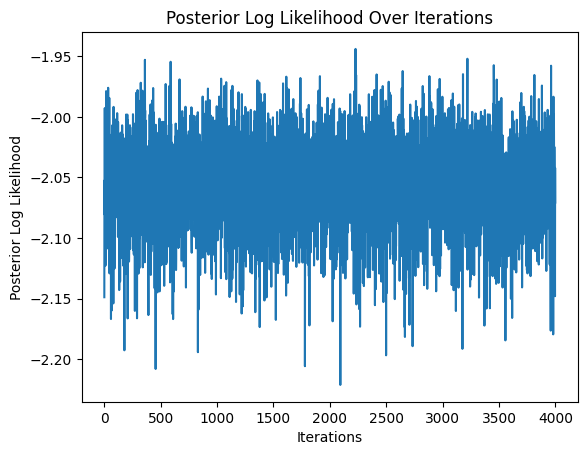

In [95]:
plt.plot(likelihoods)
plt.title("Posterior Log Likelihood Over Iterations")
plt.ylabel("Posterior Log Likelihood")
plt.xlabel("Iterations")
plt.show()

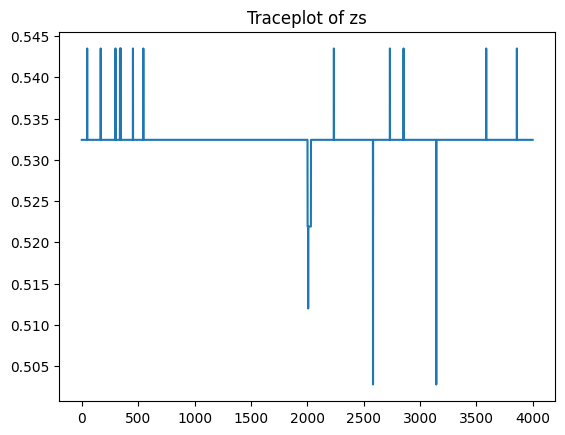

In [96]:
scores = [metrics.adjusted_rand_score(y_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

In [97]:
max_idx = np.argmax(scores)
best_zs = scores[max_idx]
best_mu = scores[max_idx]
best_sigma = scores[max_idx]
best_pi = scores[max_idx]
print(scores[max_idx])

0.5434852271998974


# 2 Missing Data with Data Sampling

1) Initialize $\mathbf{z}, \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi}$
2) For $t=0,...,T$
$$\begin{align}
    \text{Sample } \boldsymbol{\pi}^{(t)} &\sim p(\boldsymbol{pi} | \mathbf{z}^{(t-1)}) = \mathrm{Dirichlet}(\boldsymbol{\alpha}_N^{(t-1)}),\\
    &\boldsymbol{\alpha}_N^{(t-1)} = \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k^{(t-1)} = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample } \boldsymbol{\Sigma}^{(t)}, &\boldsymbol{\mu}^{(t)} \sim p(\boldsymbol{\Sigma},\boldsymbol{\mu}|\mathbf{z}^{(t-1)}, \mathbf{X})\\
     &= \prod_k^K \mathrm{NIW}(\mu,\Sigma | \mathbf{m}_N, \kappa_N, \nu_N, \mathbf{S}_N) =  \prod_k^K \mathrm{N}(\mu|\mathbf{m}_N, \frac{1}{\kappa_N}\Sigma) \times \mathrm{IW}(\Sigma | \mathbf{S}_N, \nu_N),\\
        &\qquad\qquad \mathbf{m}_{N_k} = \frac{\kappa_{0_k}m_{0_k} + N_k\bar{\mathbf{x}}_k}{\kappa_{0_k} + N_k}\\
        &\qquad\qquad \kappa_{N_k} = \kappa_{0} + N_k\\
        &\qquad\qquad \nu_{N_k} = \nu_{0} + N_k\\
        &\qquad\qquad \mathbf{S}_{N_k} = \mathbf{S}_{0_k} + \mathbf{S}_{\bar{\mathbf{x}}_k} + \frac{\kappa_{0_k}N_k}{\kappa_{0_k} + N_k}(\bar{\mathbf{x}}_k - m_{0_k})(\bar{\mathbf{x}}_k - m_{0_k})^T\\\\

    \text{Sample } \mathbf{X} \sim  p(&\mathbf{\mathbf{X}|\boldsymbol{z}^{(t-1)},\boldsymbol{\Sigma}^{(t)}, \boldsymbol{\mu}^{(t)}})\\
        \text{For } i &\in {1,..,N}\\
             &\text{Sample } \mathbf{x}_{i,H} \sim p(\mathbf{x}_{i,H}|\mathbf{x}_{i,O}, \mathbf{z}_i = k, \boldsymbol{\mu}_k^{(t)}, \boldsymbol{\Sigma}_k^{(t)}) = \mathcal{N}(\mathbf{m}_i,V_i),\quad \text{where} \\
                &\qquad \mathbf{m}_i = \boldsymbol{\mu}_H + \boldsymbol{\Sigma}_{H,O}\boldsymbol{\Sigma}_{O,O}^{-1}(\mathbf{x}_{i,O} - \boldsymbol{\mu}_O)\\
                &\qquad V_i = \boldsymbol{\Sigma}_{H,H} - \boldsymbol{\Sigma}_{H,O}\boldsymbol{\Sigma}_{O,O}^{-1}\boldsymbol{\Sigma}_{O,H}\\\\

    \text{Sample } \mathbf{z}^{(t)} \sim &P(\mathbf{z}|\mathbf{X},\boldsymbol{\pi}^{(t)}, \boldsymbol{\theta}^{(t)})\\

        \text{For } i &\in {1,..,N}\\
            &\text{Sample } z_i^{(t)} \sim \text{Categorical}(p_1^{(i)},...,p_K^{(i)}) \quad \text{where,}\\
                &\qquad p_k^{(i)} \propto \pi_k^{(t)} \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_k^{(t)},\boldsymbol{\Sigma}_k^{(t)})\\\\
\end{align}$$

Missing Data Conditional Sampling 

$$\begin{align}
    \mathbf{x}_{i,H} | \mathbf{x}_{i,O}& \sim \mathcal{N}(\mathbf{m}_i, V_i)\\\\
        \mathbf{m}_i &= \boldsymbol{\mu}_H + \boldsymbol{\Sigma}_{H,O}\boldsymbol{\Sigma}_{O,O}^{-1}(\mathbf{x}_{i,O} - \boldsymbol{\mu}_O)\\\\
        V_i &= \boldsymbol{\Sigma}_{H,H} - \boldsymbol{\Sigma}_{H,O}\boldsymbol{\Sigma}_{O,O}^{-1}\boldsymbol{\Sigma}_{O,H}

\end{align}$$

In [98]:
# With conditioning on observed pixels 
def sampleXsConditional(X, zs, μs, Σs, missing_mask):
    N, D = X.shape
    X_sample = X.copy()

    for i in range(N):
        k = zs[i].astype(int)
        μ = μs[k]
        Σ = Σs[k]

        miss_mask = missing_mask[i]
        obs_mask = ~miss_mask

        μ_h = μ[miss_mask]
        μ_o = μ[obs_mask]
        Σ_oh = Σ[obs_mask][:, miss_mask]
        Σ_ho = Σ[miss_mask][:, obs_mask]
        Σ_oo = Σ[obs_mask][:, obs_mask]
        Σ_hh = Σ[miss_mask][:, miss_mask]

        m_i = μ_h + Σ_ho @ np.linalg.inv(Σ_oo) @ (X[i,obs_mask] - μ_o)
        V_i = Σ_hh - Σ_ho @ np.linalg.inv(Σ_oo) @ Σ_oh

        X_sample[i,miss_mask] = np.random.multivariate_normal(m_i,V_i)

    return X_sample


In [99]:
# With conditional independence assumption (unconditioned on observed features)
def sampleXsIID(X, zs, μs, Σs, missing_mask):
    N, D = X.shape
    X_sample = X.copy()

    for i in range(N):
        k = zs[i].astype(int)
        μ = μs[k]
        Σ = Σs[k]
        sample =  rng.multivariate_normal(μ,Σ)
        X_sample[i, missing_mask[i]]  =sample[missing_mask[i]]

    return X_sample


In [100]:
def mean_impute(X,missing_mask):
    X_0 = X.copy()
    means = np.nanmean(np.where(missing_mask, np.nan, X), axis=0)
    X_0[missing_mask] = np.take(means, np.where(missing_mask)[1])
    return X_0

In [110]:
def gibbs_missing(X, num_iter, num_burn,K, iid=False, rng=np.random.default_rng(random_seed), eps=1e-20) :
    N,D = X.shape

    logliks = []

    missing_mask = np.isnan(X)

    πs = []
    zs = []
    Σs = []
    μs = []
    xs = []

    # Intialize
    α_0 = np.full(K, 1 / K)  # Dirichlet
    k_0 = 0.01         # Prior confidence in μ_0
    μ_0 = np.zeros(D)  # Prior mean vector 
    ν_0 = D + 1        # DOF for inverse wishart
    S_0 = np.eye(D)# prior scatter matrix

    π = rng.dirichlet(α_0)
    z = np.random.randint(0,K,size=N)
    x = mean_impute(X,missing_mask)
    Σ,μ = sample_NIW(x,z,μ_0,S_0,k_0,ν_0,K)

    for t in range(1,num_iter+num_burn):
        π = sample_π(z, α_0, K)

        if (iid) : 
            x = sampleXsIID(X,z,μ,Σ,missing_mask)
        else :
            x = sampleXsConditional(X,z,μ,Σ,missing_mask)

        Σ,μ = sample_NIW(x,z,μ_0,S_0,k_0,ν_0,K)

        p, loglik = gaussian_likelihood(x,μ,Σ,π)

        z = sampleZs(p)

        if t > num_burn:
            πs.append(π.copy())
            zs.append(z.copy())
            Σs.append(Σ.copy())
            μs.append(μ.copy())
            xs.append(x.copy())
            logliks.append(loglik)

    return zs[num_burn:], Σs[num_burn:], μs[num_burn:], πs[num_burn:], logliks

In [102]:
import random
N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [103]:
zs,Σs,μs,πs,logliks= gibbs_missing(X_cover1, 100, 25, iid=False,K=3)

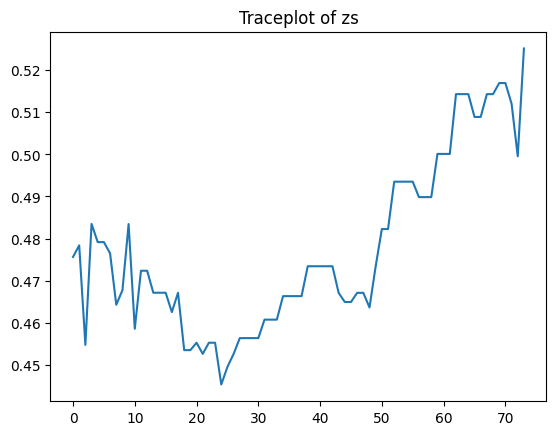

In [104]:
scores = [metrics.adjusted_rand_score(y_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

In [111]:
zs,Σs,μs,πs,logliks= gibbs_missing(X_cover1, 100, 25, iid=True,K=3)

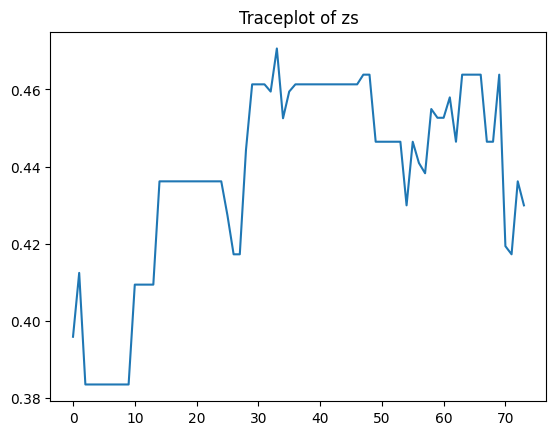

In [112]:
scores = [metrics.adjusted_rand_score(y_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

In [135]:
import random
N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
phi = rng.uniform(0.1, 0.9, size=(3, D))   # cluster × feature miss-prob

mask = rng.random((N, D)) < phi[y_train]    # (N,D) boolean, True = missing

rows_all_nan = np.where(mask.all(axis=1))[0]  # indices of offending rows
if rows_all_nan.size:
    # pick one random column per offending row and flip it to observed
    rand_cols = rng.integers(0, D, size=rows_all_nan.size)
    mask[rows_all_nan, rand_cols] = False 
    
X_cover1[mask] = np.nan

In [136]:
zs,Σs,μs,πs,logliks= gibbs_missing(X_cover1, 100, 25, iid=False,K=3)

ValueError: cannot reshape array of size 0 into shape (0)